In [ ]:
!pip install tensorflow
!pip install rdkit
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 54.5 MB/s eta 0:00:00


In [ ]:
import fileinput
from google.colab import drive
drive.mount('/content/drive/')

# # Move to the shared working directory and list what is there
%cd /content/drive/Shareddrives/Computational-Materials-Science-Group/Graph-Neural-Networks/Linker-data

Mounted at /content/drive/
/content/drive/Shareddrives/Computational-Materials-Science-Group/Graph-Neural-Networks/Linker-data


In [ ]:
import pickle
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [ ]:
with open('GCNN-data-2.pickle', 'rb') as f:
  raw_data = pickle.load(f)

In [ ]:
print(raw_data.keys())

dict_keys(['smiles', 'intensity', 'mass', 'moment', 'graph', 'max_atoms', 'omit_list'])


In [ ]:
n_features = 9
def gen_smiles2graph(sml):
  m = rdkit.Chem.MolFromSmiles(sml)
  m = rdkit.Chem.AddHs(m)
  order_string = {
      rdkit.Chem.rdchem.BondType.SINGLE: 1,
      rdkit.Chem.rdchem.BondType.DOUBLE: 2,
      rdkit.Chem.rdchem.BondType.TRIPLE: 3,
      rdkit.Chem.rdchem.BondType.AROMATIC: 4,
  }

  N = len(list(m.GetAtoms()))
  nodes = (np.zeros((N, n_features)))
  for i in m.GetAtoms():
    #[index of atom in molecule, atomic number]
    nodes[i.GetIdx(), i.GetAtomicNum()] = 1

  adj = np.zeros((N, N))
  for j in m.GetBonds():
    u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
    v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
    order = j.GetBondType()
    if order in order_string:
      order = order_string[order]
    else:
      raise Warning("Ignoring bond order" + order)
    adj[u, v] = 1
    adj[v, u] = 1
  adj += np.eye(N)
  return nodes, adj

In [ ]:
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

In [ ]:
class GRLayer(tf.keras.layers.Layer):
    """A GNN layer that computes average over all node features"""

    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_sum(nodes, axis=1)
        return reduction

In [ ]:
ninput = tf.keras.Input(
    (
        None,
        n_features,
    )
)
ainput = tf.keras.Input(
    (
        None,
        None,
    )
)
# GCN block
x = GCNLayer("relu")([ninput, ainput])
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
x = GCNLayer("relu")(x)
# reduce to graph features
x = GRLayer()(x)
# standard layers (the readout)
x = tf.keras.layers.Dense(16, "tanh")(x)
x = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=(ninput, ainput), outputs=x)

In [ ]:
#print(raw_data['moment'])

first_moment_value = []
second_moment_value = []
third_moment_value = []
raw_data['first_moment_normalized'] = []
for key, value in raw_data['moment'].items():
  first_moment_value.append(raw_data['moment'][key][0])
  second_moment_value.append(raw_data['moment'][key][1])
  third_moment_value.append(raw_data['moment'][key][2])

first_moment_list = np.array(first_moment_value)
first_moment_list -= np.min(first_moment_list)
first_moment_list /= np.max(first_moment_list)
# second_moment_list = np.array(second_moment_value).reshape(-1, 1)
# third_moment_list = np.array(third_moment_value).reshape(-1, 1)
# first_moment_normalized = list(normalize(first_moment_list))
# second_moment_normalized = list(normalize(second_moment_list))
# third_moment_normalized = list(normalize(third_moment_list))

# print(first_moment_normalized[0][1])
print(first_moment_list)

[0.24187215 0.2202675  0.14889209 ... 0.10887366 0.04193992 0.41328582]


In [ ]:
print(second_moment_normalized[0][1])

0.012401242665747436


In [ ]:
def example():
  k = 0
  for i in raw_data['smiles'].values():
    graph = gen_smiles2graph(i)
    mom = first_moment_list[k]
    k += 1
    yield graph, mom


data = tf.data.Dataset.from_generator(
    example,
    output_types=((tf.float32, tf.float32), tf.float32),
    output_shapes=(
        (tf.TensorShape([None, n_features]), tf.TensorShape([None, None])),
        tf.TensorShape([]),
    ),
)

In [ ]:
# for i in raw_data['moment'].values():
#   print(i)

[19.133685450624917, 4.516380812276007, 1.194841700619548]
[17.76604124774494, 8.939708926913777, 0.466354166281819]
[13.247745691772916, 2.0119384193213574, 0.9813287414053931]
[16.400043353536187, 4.198934944170233, 1.1121156477239833]
[8.980429488182404, 3.70810224272221, 0.24016523211399893]
[20.664641086064872, 4.087466017776428, 0.7955564668016181]
[28.83889775432829, 6.011835840493308, 1.0556109665325395]
[14.180011735735258, 7.065516167025953, 0.8663498001403022]
[12.675519069923585, 3.6345131017434613, 2.3399885572113313]
[14.761027907572226, 6.516149055129615, 1.5643268652968376]
[11.660566322591041, 4.882799011056655, 2.517897676163563]
[21.013232347033167, 8.2574334486278, 1.460235479080671]
[19.236210086250072, 8.039629867631554, 1.1962874938641843]
[8.733795686448701, 2.722079609895795, 1.2526818006718823]
[9.88831432674192, 5.3327904536999275, 1.2824208909804307]
[17.445034921771132, 4.154653284702798, 0.9138620019328827]
[20.770282030971153, 5.653476191020112, 0.7334990

In [ ]:
test_data = data.take(1928)
val_data = data.skip(1928).take(1928)
train_data = data.skip(3856)

In [ ]:
model.compile("adam", loss="mean_squared_error")
result = model.fit(train_data.batch(1), validation_data=val_data.batch(1), epochs=10)

Epoch 1/10
   1902/Unknown 11s 3ms/step - loss: 0.0069

[20:50:44] WARNING: not removing hydrogen atom without neighbors


   8693/Unknown 31s 3ms/step - loss: 0.0067

[20:51:04] WARNING: not removing hydrogen atom without neighbors


  15343/Unknown 57s 3ms/step - loss: 0.0067

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - loss: 0.0067 - val_loss: 0.0083
Epoch 2/10
 1864/15352 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - loss: 0.0069

[20:51:50] WARNING: not removing hydrogen atom without neighbors


 8747/15352 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0067

[20:52:16] WARNING: not removing hydrogen atom without neighbors


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.0066 - val_loss: 0.0082
Epoch 3/10
 1897/15352 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 0.0068

[20:53:13] WARNING: not removing hydrogen atom without neighbors


 8746/15352 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.0066

[20:53:40] WARNING: not removing hydrogen atom without neighbors


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - loss: 0.0066 - val_loss: 0.0082
Epoch 4/10
 1890/15352 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - loss: 0.0068

[20:54:26] WARNING: not removing hydrogen atom without neighbors


 8772/15352 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0066

[20:54:51] WARNING: not removing hydrogen atom without neighbors


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.0065 - val_loss: 0.0081
Epoch 5/10
 1864/15352 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 0.0067

[20:55:45] WARNING: not removing hydrogen atom without neighbors


 8734/15352 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0065

[20:56:11] WARNING: not removing hydrogen atom without neighbors


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 6/10
 1887/15352 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 0.0066

[20:56:54] WARNING: not removing hydrogen atom without neighbors


 8754/15352 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0064

[20:57:20] WARNING: not removing hydrogen atom without neighbors


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 7/10
 1900/15352 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 0.0065

[20:58:03] WARNING: not removing hydrogen atom without neighbors


 8748/15352 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0063

[20:58:28] WARNING: not removing hydrogen atom without neighbors


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - loss: 0.0063 - val_loss: 0.0081
Epoch 8/10
 1881/15352 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - loss: 0.0065

[20:59:12] WARNING: not removing hydrogen atom without neighbors


 8744/15352 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0063

[20:59:35] WARNING: not removing hydrogen atom without neighbors


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - loss: 0.0063 - val_loss: 0.0080
Epoch 9/10
 1905/15352 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.0065

[21:00:31] WARNING: not removing hydrogen atom without neighbors


 8768/15352 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0062

[21:00:51] WARNING: not removing hydrogen atom without neighbors


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 0.0062 - val_loss: 0.0079
Epoch 10/10
 1906/15352 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.0064

[21:01:26] WARNING: not removing hydrogen atom without neighbors


 8758/15352 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0062

[21:01:44] WARNING: not removing hydrogen atom without neighbors


15352/15352 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 0.0062 - val_loss: 0.0080


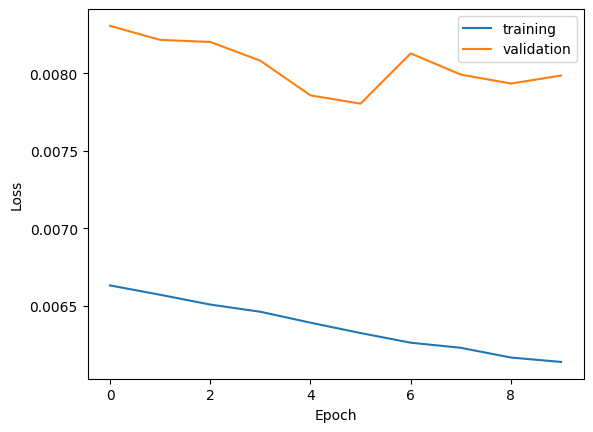

In [ ]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

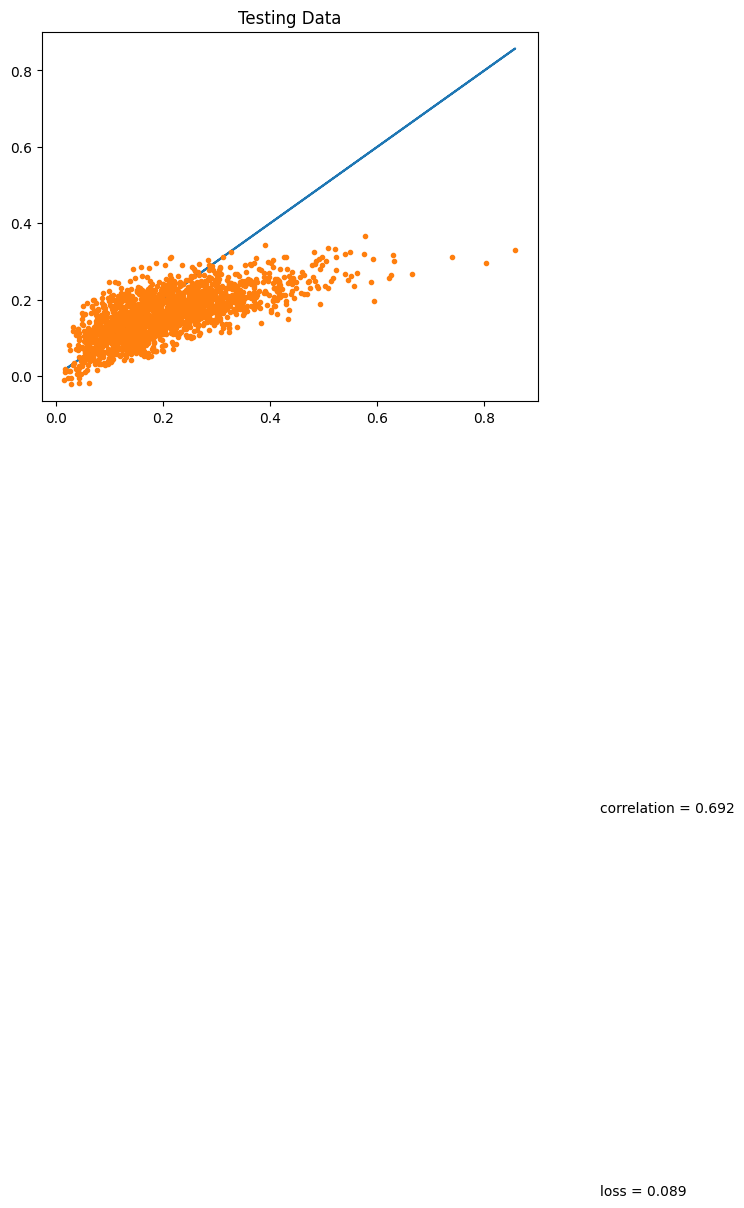

In [ ]:
yhat = model.predict(test_data.batch(1), verbose=0)[:, 0]
test_y = [y for x, y in test_data]
plt.figure()
plt.plot(test_y, test_y, "-")
plt.plot(test_y, yhat, ".")
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()